In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18,googlenet, densenet121,mobilenet_v3_small,mobilenet_v3_large
from sklearn.model_selection import train_test_split
from PIL import Image


In [5]:
def multiple_dir_files_to_df(dirs, label):
    df = pd.DataFrame()
    for idx,dir in enumerate(dirs):
        files = os.listdir(dir)
        files = [dir + '/' + file for file in files]
        df = pd.concat([df,pd.DataFrame({'file': files, 'label': label[idx]})])
    return df

common_path="Image/"

labels=["neutral","happy","sad","fear","angry","surprise","disgust"]

database=[common_path+label for label in labels]


In [6]:
def training_test_model(train_loader,test_loader,model,model_name,epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True):
    # Initialiser le modèle et le journal
    model = model
    patience = early_stopping_patience
    best_val_loss = float('inf')
    counter = 0
    accuracy_test_list=[]
    accuracy_train_list=[]
    loss_test_list=[]
    loss_train_list=[]
    
    # Entraîner le modèle
    num_epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=gamma)
    # Entraîner le modèle
    for epoch in range(num_epochs):
        accuracy_train=[]
        loss_train=[]
        accuracy_test=[]
        loss_test=[]
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]

        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())

            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            likelihood, predictions = scores.max(1)
            loss_train.append(loss.item())
            accuracy_train.append((predictions == targets).float().mean().item())

            # gradient descent or adam step
        scheduler.step()

        model.eval()
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_test.append(loss.item())
            accuracy_test.append((predictions == targets).float().mean().item())

        accuracy_train=np.array(accuracy_train).mean()
        loss_train=np.array(loss_train).mean()
        accuracy_test=np.array(accuracy_test).mean()
        loss_test=np.array(loss_test).mean()
        accuracy_test_list.append(accuracy_test)
        accuracy_train_list.append(accuracy_train)
        loss_test_list.append(loss_test)
        loss_train_list.append(loss_train)
        
        if early_stopping_save:
            if loss_test < best_val_loss:
                best_val_loss = loss_test
                counter = 0
            else:
                counter += 1
            if counter > patience:
                print("Early stopping at epoch: ",epoch)
                print("Saving model...")
                torch.save(model.state_dict(), f"./models/{model_name+'_'+str(epoch)}.pth")
                return accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list
        print(f"Train epoch: {epoch}, accuracy = {accuracy_train} ,loss = {loss_train}, lr = {np.round(current_lr,6)}")
        print(f"Test epoch: {epoch}, accuracy = {accuracy_test} ,loss = {loss_test}")
    torch.save(model.state_dict(), f"./models/{model_name}.pth")
    return accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list

In [7]:
def plot_train_loss(accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list,model_name):
    plt.figure(figsize=(10,5))
    plt.plot(accuracy_test_list,label="accuracy_test")
    plt.plot(accuracy_train_list,label="accuracy_train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for "+model_name+" model")
    plt.legend()
    plt.figure(figsize=(10,5))
    plt.plot(loss_test_list,label="loss_test")
    plt.plot(loss_train_list,label="loss_train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss for "+model_name+" model")
    plt.legend()

In [8]:
df = multiple_dir_files_to_df(database,np.linspace(0,6,7))
X,y=df["file"].tolist(),df["label"].tolist()

#Split the dataset into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

print("Train head: ",X_train[:5],"\n",y_train[:5])
print("Test head: ",X_test[:5],"\n",y_test[:5])

Train head:  ['Database/neutral/01_101.jpg', 'Database/angry/05_057.jpg', 'Database/disgust/07_179.jpg', 'Database/angry/05_195.jpg', 'Database/happy/02_011.jpg'] 
 [0.0, 4.0, 6.0, 4.0, 1.0]
Test head:  ['Database/neutral/01_202.jpg', 'Database/happy/02_092.jpg', 'Database/sad/03_032.jpg', 'Database/happy/02_142.jpg', 'Database/disgust/07_215.jpg'] 
 [0.0, 1.0, 2.0, 1.0, 6.0]


In [9]:
# Définir un Dataset personnalisé
class CustomDataset(Dataset):
    def __init__(self, file_names, labels, transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = f'{self.file_names[idx]}' 
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label


In [10]:
# Define the image transformations
transform = transforms.Compose([
    transforms.CenterCrop((500, 500)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [11]:
# Créer les jeux de données et les chargeurs de données
train_dataset = CustomDataset(X_train, y_train, transform)
test_dataset = CustomDataset(X_test, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier[3] = nn.Linear(1024, 7)
    def forward(self, x):
        return self.mobilenet(x)
        
print(MobileNet())

MobileNet(
  (mobilenet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv

In [ ]:
model=MobileNet()
accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list=training_test_model(train_loader,test_loader,model,"MobileNet",epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True)

In [16]:
class MobileNetLarge(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
        self.mobilenet.classifier[3] = nn.Linear(1280, 7)

    def forward(self, x):
        return self.mobilenet(x)
        
print(MobileNetLarge())

MobileNetLarge(
  (mobilenet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActi

In [ ]:
model=MobileNetLarge()
accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list=training_test_model(train_loader,test_loader,model,"MobileNetLarge",epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True)

In [9]:
class GoogleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.googlenet = googlenet(pretrained=True)
        self.googlenet.fc = nn.Linear(512, 7)
        self.googlenet.inception4d=nn.Identity()
        self.googlenet.inception4e=nn.Identity()
        self.googlenet.inception5a=nn.Identity()
        self.googlenet.inception5b=nn.Identity()

    def forward(self, x):
        return self.googlenet(x)

model= GoogleNet()
print(model)

GoogleNet(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

/home/david/miniconda3/envs/DL-ENV/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/david/miniconda3/envs/DL-ENV/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
accuracy_test_list_googlenet,accuracy_train_list_googlenet,loss_test_list_googlenet,loss_train_list_googlenet=training_test_model(train_loader,test_loader,model,"googlenet_pretrained_7_emo",learning_rate=0.002,epochs=50,early_stopping_save=True)
torch.cuda.empty_cache()

Train epoch: 0, accuracy = 0.6419753086419753 ,loss = 0.9693492882781558, lr = 0.002
Test epoch: 0, accuracy = 0.5744047619047619 ,loss = 1.167264509768713
Train epoch: 1, accuracy = 0.8094135802469136 ,loss = 0.5354853715793586, lr = 0.0018
Test epoch: 1, accuracy = 0.27380952380952384 ,loss = 2.3479710192907426
Train epoch: 2, accuracy = 0.8425925925925926 ,loss = 0.4460470119928136, lr = 0.00162
Test epoch: 2, accuracy = 0.6696428571428571 ,loss = 1.0158797871498835
Train epoch: 3, accuracy = 0.8757716049382716 ,loss = 0.33013854221797284, lr = 0.001458
Test epoch: 3, accuracy = 0.7202380952380952 ,loss = 0.8585998859433901
Train epoch: 4, accuracy = 0.9158950617283951 ,loss = 0.256166331332039, lr = 0.001312
Test epoch: 4, accuracy = 0.7619047619047619 ,loss = 0.7351849471174535
Train epoch: 5, accuracy = 0.9483024691358025 ,loss = 0.15921131939983663, lr = 0.001181
Test epoch: 5, accuracy = 0.6934523809523809 ,loss = 1.024234353076844
Train epoch: 6, accuracy = 0.9513888888888888 

KeyboardInterrupt: 

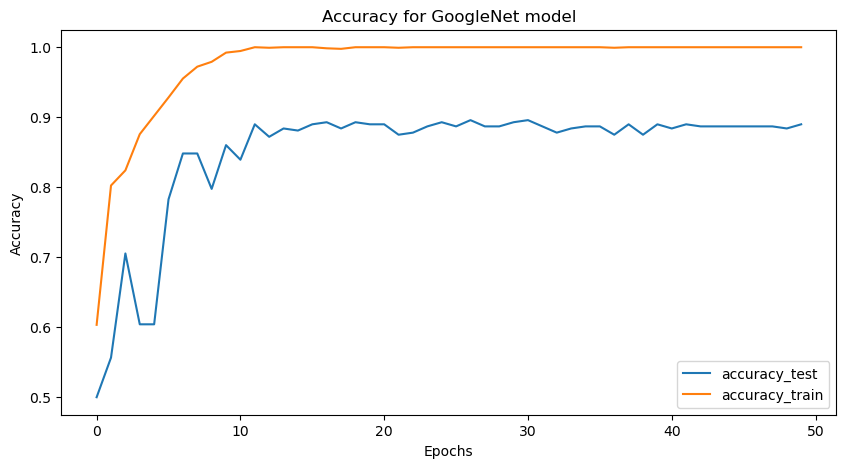

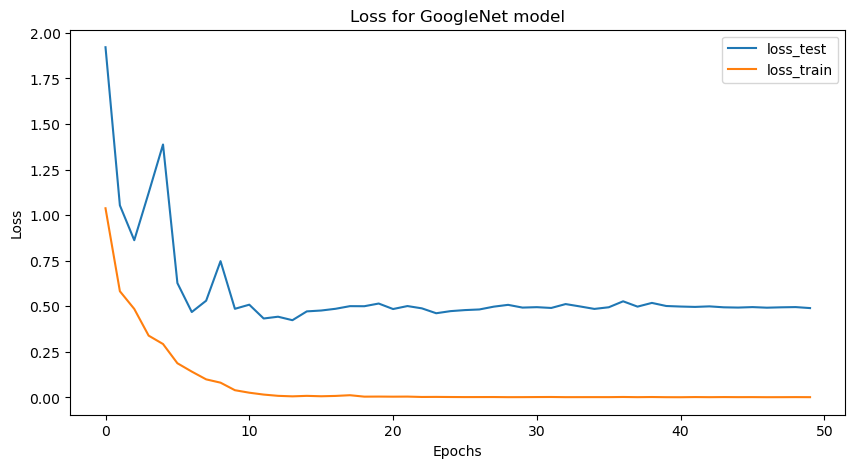

In [ ]:
plot_train_loss(accuracy_test_list_googlenet,accuracy_train_list_googlenet,loss_test_list_googlenet,loss_train_list_googlenet,"GoogleNet")

In [13]:
# Définir le modèle ResNet
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet = densenet121(pretrained=True)

    def forward(self, x):
        return self.densenet(x)

model= DenseNet()
print(model)

DenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

C:\Users\fluff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fluff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
accuracy_test_list_densenet,accuracy_train_list_densenet,loss_test_list_densenet,loss_train_list_densenet=training_test_model(train_loader,test_loader,model,"densenet_pretrained_7_emo",learning_rate=0.002,epochs=50,early_stopping_save=True)
torch.cuda.empty_cache()

Train epoch: 0, accuracy = 0.5478395061728395 ,loss = 1.3860077011732408, lr = 0.002
Test epoch: 0, accuracy = 0.5505952380952381 ,loss = 1.3669875122251964
Train epoch: 1, accuracy = 0.7121913580246914 ,loss = 0.7405882096952863, lr = 0.0018
Test epoch: 1, accuracy = 0.6160714285714286 ,loss = 0.9858401984508548
Train epoch: 2, accuracy = 0.7638888888888888 ,loss = 0.6375036820953275, lr = 0.00162
Test epoch: 2, accuracy = 0.7559523809523809 ,loss = 0.7646205858105705
Train epoch: 3, accuracy = 0.8233024691358025 ,loss = 0.4813533400495847, lr = 0.001458
Test epoch: 3, accuracy = 0.7380952380952381 ,loss = 0.7924499483335585
Train epoch: 4, accuracy = 0.8518518518518519 ,loss = 0.4162701133776594, lr = 0.001312
Test epoch: 4, accuracy = 0.7738095238095238 ,loss = 0.6763848250820523
Train epoch: 5, accuracy = 0.8734567901234568 ,loss = 0.3694924710341442, lr = 0.001181
Test epoch: 5, accuracy = 0.7619047619047619 ,loss = 0.7488864307247457
Train epoch: 6, accuracy = 0.9290123456790124 

In [ ]:
# Définir le modèle ResNet
class ResNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(256, 7)
        self.resnet.layer4= nn.Identity()
        self.resnet.layer1[-1].bn2 = nn.Sequential(
            self.resnet.layer1[-1].bn2,
            nn.Dropout2d(p=0.15)
        )

        self.resnet.layer2[-1].bn2 = nn.Sequential(
            self.resnet.layer2[-1].bn2,
            nn.Dropout2d(p=0.15)
        )

        self.resnet.layer3[-1].bn2 = nn.Sequential(
            self.resnet.layer3[-1].bn2,
            nn.Dropout2d(p=0.15)
        )

    def forward(self, x):
        return self.resnet(x)

model= ResNetModel()
print(model)

/home/david/miniconda3/envs/DL-ENV/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
accuracy_test_list_resnet,accuracy_train_list_resnet,loss_test_list_resnet,loss_train_list_resnet=training_test_model(train_loader,test_loader,model,"resnet_18_pretrained_7_emo",learning_rate=0.0025,epochs=50,early_stopping_save=True)
torch.cuda.empty_cache()

Train epoch: 0, accuracy = 0.44521604938271603 ,loss = 1.3837088802714406, lr = 0.0025
Test epoch: 0, accuracy = 0.2648809523809524 ,loss = 1.85695181006477
Train epoch: 1, accuracy = 0.5964506172839507 ,loss = 0.9694095246585799, lr = 0.00225
Test epoch: 1, accuracy = 0.33630952380952384 ,loss = 2.8746927068347023
Train epoch: 2, accuracy = 0.6674382716049383 ,loss = 0.8118692864606409, lr = 0.002025
Test epoch: 2, accuracy = 0.6845238095238095 ,loss = 0.7792682292915526
Train epoch: 3, accuracy = 0.7137345679012346 ,loss = 0.7133966621793346, lr = 0.001823
Test epoch: 3, accuracy = 0.5327380952380952 ,loss = 1.13748490242731
Train epoch: 4, accuracy = 0.7299382716049383 ,loss = 0.6727511297773432, lr = 0.00164
Test epoch: 4, accuracy = 0.47023809523809523 ,loss = 1.4702822253817605
Train epoch: 5, accuracy = 0.7700617283950617 ,loss = 0.5722976045476066, lr = 0.001476
Test epoch: 5, accuracy = 0.5654761904761905 ,loss = 0.9766925374666849
Train epoch: 6, accuracy = 0.7739197530864198

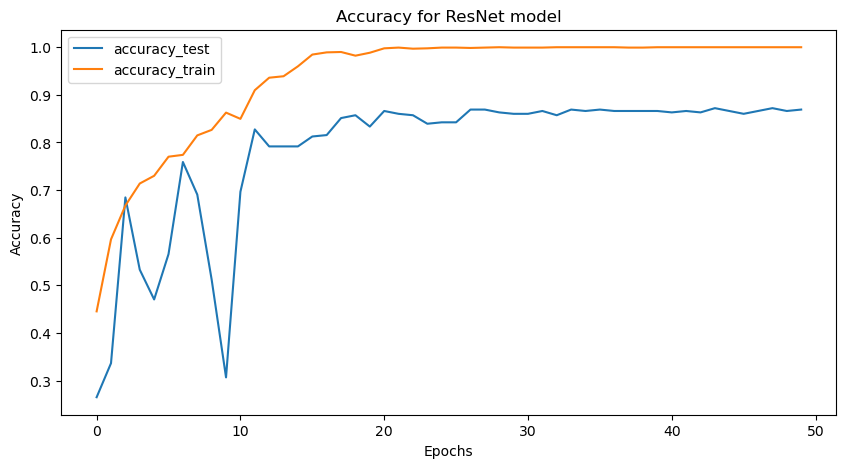

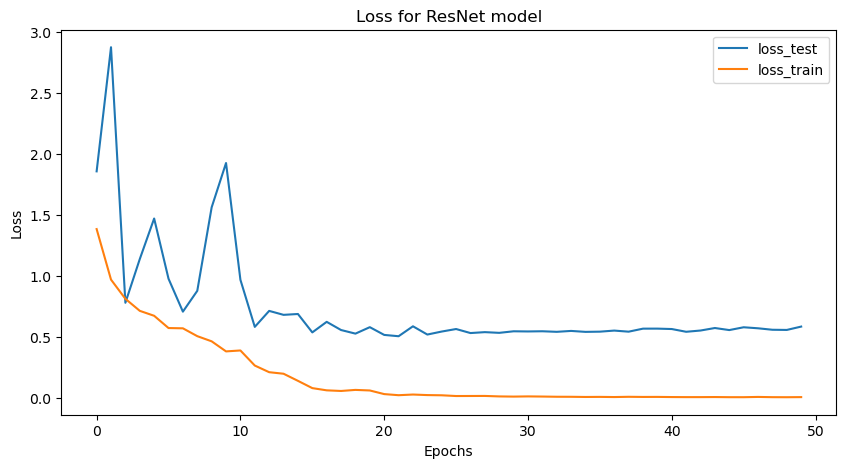

In [ ]:
plot_train_loss(accuracy_test_list_resnet,accuracy_train_list_resnet,loss_test_list_resnet,loss_train_list_resnet,"ResNet")